In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
# LIBRARIES

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


In [ ]:
csv_file_path = '/content/gdrive/MyDrive/processati_email/df_features3_DIRECTED_completo.csv'  # Specify the file path where you want to save the CSV

df_features= pd.read_csv(csv_file_path)

df_anagrafici_excel = pd.read_excel(io = "/content/gdrive/MyDrive/Colab Notebooks/Dati per POLIMI RIVISTO_OUTPUT.xlsx", engine='openpyxl', sheet_name= 'OUTPUT')


In [ ]:
#//////////////// NUMERICHE SUL DATASET FINALE DELLE FEATURESSSSSSSSSSSSSSSSS\\\\\\\\\\\\\\\\\\\


print(df_features.describe().to_string())
print()
print()
#print(finale_features.info())

print()
print()
print(df_features.columns)


               Età   WE_average   JS_average  AOC_average   OJ_average   MT_average   EQ_average  in_degree_DIR  out_degree_DIR  betweenness_DIR  closeness_DIR     pageRank  influenceIndex  contribution_index    Community  OtherNodesWithDistinctCommunity  CommunityBridgeIndex  addettoVSmanager  performance    seniority  retribuzione  total_sent_email  total_received_email  #persone_interazioni  sent_to_EXTERNAL  received_from_EXTERNAL  sent_to_CONSULENTI  received_from_CONSULENTI  people_sent_SAME_bu_SUP  email_sent_SAME_bu_SUP  people_sent_SAME_bu_INF  email_sent_SAME_bu_INF  email_sent_different_bu_SUP  people_sent_different_bu_SUP  people_sent_different_bu_INF  email_sent_different_bu_INF  people_received_SAME_bu_SUP  email_received_SAME_bu_SUP  people_received_SAME_bu_INF  email_received_SAME_bu_INF  people_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_SUP  email_received_DIFFERENT_bu_INF  people_received_DIFFERENT_bu_INF  total_SAME_bu_SUP  people_total_SAME_bu_SUP  total

In [ ]:
"""

"""

print(len(df_features[ df_features['addettoVSmanager']==1]))
print(len(df_features[ df_features['addettoVSmanager']==0]))

370
1657


In [ ]:
"""
I. Studio: la centralità delle persone all'interno della BU
Andiamo ora a studiare com'è la struttura di CREDEM e cosa possiamo inferire semplicemente osservando lo scambio di e-mail

Per ogni BU andiamo a studiare chi sono le persone più centrali,
cioé quelle che si trovano nei percorsi più brevi e che quindi possono avere più facilmente accesso alle informazioni.

Per fare ciò:
1. andiamo a calcolare per ogni persona le quuattro principali metriche di centralità all'interno della pripria BU
2. Definiamo un ranking per ciascuna di queste metriche (le ordiniamo in modo decrescente)
3. Per ogni BU, per ciascuna metrica andiamo a prendere le prime 20 persone (prendo le prime 20 perché in media le BU, nei nostri dati, hanno 30 persone)
4. facciamo l'intersezione di queste 4 x top20 classifiche in modo tale da ottenere in assoluto le persone più centrali

RISULTATI:

Number of managers in the total intersection: 173/370 (46%)
Number of addetti in the total intersection: 277/1657 (16%)

Troviamo che su 270 Manager 173 sono figure centrali, però il dato più interessante è che il gruppo maggiore di persone centrali è quello degli addetti!

Andando però a confrontarli sul totale, avendo diciamo una misura assoluta,
otteniamo una lettura differente, cioé il 46% dei managers è centrale, mentre solo il 16% degli addetti lo è.


Questo conferma il fatto che:
>>>>>>>>>>>>>>>>>>>>>>>>> le persone più centrali in ogni BU sono i Manager!


OSS: utilizza il pannello "Centrality within BU" per andare a fare vedere i risultati in maniera più raffinata, avendo la possibilità di poter scegliere per BU


POSSIBILE DOMANDA:
-come mai fai l'intersezione? perché le metriche di centalità per definizione sono correlate tra di loro (basate su shortest path e numero di contatti)> questa parte di analisi si trova nella sezione sulla regressione

"""

'\nI. Studio: la centralità delle persone all\'interno della BU\nAndiamo ora a studiare com\'è la struttura di CREDEM e cosa possiamo inferire semplicemente osservando lo scambio di e-mail\n\nPer ogni BU andiamo a studiare chi sono le persone più centrali,\ncioé quelle che si trovano nei percorsi più brevi e che quindi possono avere più facilmente accesso alle informazioni.\n\nPer fare ciò: \n1. andiamo a calcolare per ogni persona le quuattro principali metriche di centralità all\'interno della pripria BU\n2. Definiamo un ranking per ciascuna di queste metriche (le ordiniamo in modo decrescente)\n3. Per ogni BU, per ciascuna metrica andiamo a prendere le prime 20 persone (prendo le prime 20 perché in media le BU, nei nostri dati, hanno 30 persone)\n4. facciamo l\'intersezione di queste 4 x top20 classifiche in modo tale da ottenere in assoluto le persone più centrali \n\nRISULTATI:\n\nNumber of managers in the total intersection: 173/370 (46%)\nNumber of addetti in the total intersect

In [ ]:
##################################################### TROVO LE PERSONE PIù CENTRALI PER OGNI BU ####################################################################################


# Features I'm intereste in
metrics = ['in_degree_BU', 'out_degree_BU', 'betweenness_BU', 'closeness_BU']

# list of user_id of the managers of the total intersection
manager_intersection = []


# list of user_id of the addetti of the total intersection
addetto_intersection = []


for bu_sup in df_features['BU_sup'].unique():
    print(f"Business Unit: {bu_sup}")

    #I take all the people of a specific BU
    bu_df = df_features[df_features['BU_sup'] == bu_sup]

    # dict to save the top 20 for each of the 4 features, format: ()'feature-name': ndarray of the 20 top people)
    top_20_dfs = {}

    # for each of the 4 features I take the top 20 people with the highest value and I store them in the dict
    for metric in metrics:
        top_20_dfs[metric] = bu_df.nlargest(20, metric)

    # Compute the intersection among the 4 groups of 20 people
    intersection_all = set.intersection(*[set(top_20_dfs[metric]['user_ID']) for metric in metrics])

    # Snumber of people in the intersection of all the 4 top 20
    print("Total intersection size:", len(intersection_all))

    # it prints the "most central" people, the ones that are in top 20 in each of the 4 rankings
    print("Intersection of all groups:")
    for user_id in intersection_all:
        manager_status = bu_df[bu_df['user_ID'] == user_id]['addettoVSmanager'].iloc[0] # I extract whether is an addetto or a manager
        if manager_status == 0:
            role = 'addetto'
            addetto_intersection.append(user_id)  # Aggiungi l'user_ID alla lista addetto
        else:
            role = 'manager'
            manager_intersection.append(user_id)  # Aggiungi l'user_ID alla lista manager
        print(f"User ID: {user_id}, addettoVSmanager: {role}")

    # I check how many people are in the intersection between each couple of features
    for i in range(len(metrics)):
        for j in range(i + 1, len(metrics)):
            metric1 = metrics[i]
            metric2 = metrics[j]

            intersection = set(top_20_dfs[metric1]['user_ID']).intersection(top_20_dfs[metric2]['user_ID'])
            print(f"Intersection between {metric1} and {metric2}: {len(intersection)} user_ID in comune")

    print("\n")


print("Number of managers in the total intersection:", len(manager_intersection))
print("Number of addetti in the total intersection:", len(addetto_intersection))


Business Unit: RPB
Total intersection size: 7
Intersection of all groups:
User ID: eI42tO7aSbicJjU2cc3xDg, addettoVSmanager: manager
User ID: VB5CfplgRIqkSLxeARMYAg, addettoVSmanager: manager
User ID: qUSFZT0ISGaHkpSNUqAk-A, addettoVSmanager: manager
User ID: Sk5fj1iZQT2re452asTkGw, addettoVSmanager: manager
User ID: A_iQGsuiRaOo9iGCzQuShg, addettoVSmanager: manager
User ID: f5eRIZdFRficSj_ed10qIA, addettoVSmanager: addetto
User ID: _Ev-AfriQf-guei1xxdmkQ, addettoVSmanager: addetto
Intersection between in_degree_BU and out_degree_BU: 19 user_ID in comune
Intersection between in_degree_BU and betweenness_BU: 14 user_ID in comune
Intersection between in_degree_BU and closeness_BU: 9 user_ID in comune
Intersection between out_degree_BU and betweenness_BU: 14 user_ID in comune
Intersection between out_degree_BU and closeness_BU: 8 user_ID in comune
Intersection between betweenness_BU and closeness_BU: 10 user_ID in comune


Business Unit: CESER
Total intersection size: 10
Intersection of a

In [ ]:
"""

Scegli 3 Business unit ed utilizza neo4j per far vedere le persone più centrali:

potrei prendere:
- CESER 10
- GOVREL 10-
- AMMIN 12
- PEOPLE 9
- CDMTEL 11
-ERISK 15
- DT71 11
"""

In [ ]:
"""

Delle persone più centrali sono interessato a sapere:
1) Ruolo: Quali sono i ruoli o le posizioni lavorative di queste persone? Svolgono funzioni manageriali, tecniche o di coordinamento?

2) Comunicazione: Con chi comunicano più spesso? Comunicano prevalentemente all'interno del loro gruppo o attraverso diversi gruppi?

3) Influenza: I loro suggerimenti o decisioni hanno un impatto significativo sull'azienda? Sono spesso coinvolti in decisioni chiave?

4) Mediazione: Sono coinvolti in scambi tra gruppi diversi? Agiscono come ponti tra reparti o team separati?

"""

In [ ]:
#######################################################     RUOLO    #################################################################################

# DOMANDE:
# Quali sono i ruoli o le posizioni lavorative di queste persone?
# Svolgono funzioni manageriali, tecniche o di coordinamento?


# Filtraggio del DataFrame in base alle liste
filtered_df = df_anagrafici_excel[
    df_anagrafici_excel['CODICI RISPONDENTI'].isin(manager_intersection + addetto_intersection)
]

# Seleziona solo le colonne specifiche
selected_columns = ['CODICI RISPONDENTI' ,'Posizione', 'Descrizione ruolo', 'UO sup']
result_df = filtered_df[selected_columns]

# Stampa il DataFrame risultante
#print(result_df.to_string())


print()
print()

# Stampa il conteggio delle persone per ciascuna posizione
position_counts = result_df.groupby('Descrizione ruolo').size().sort_values(ascending=False)
#print(position_counts.to_string())

print()
print()

print(pd.pivot_table(result_df, index=['Descrizione ruolo', 'Posizione'], values=['CODICI RISPONDENTI'], aggfunc=[np.count_nonzero]).sort_values(by=('count_nonzero', 'CODICI RISPONDENTI'), ascending=False).to_string())






                                                                  count_nonzero
                                                             CODICI RISPONDENTI
Descrizione ruolo                                  Posizione                   
RDF - RESPONSABILE DI FILIALE                      Manager                   45
CL - COMPETENCE LEADER                             Addetto                   18
EXPALS - EXPERT AFFARI LEGALI E SOCIETARI          Addetto                   15
CMR - MARKET LEADER RETAIL                         Manager                   14
TL - TEAM LEADER                                   Manager                   14
EXPCOM - EXPERT COMPLIANCE E/O ANTIRICICLAGGIO     Addetto                   11
CS - CAPO SERVIZIO                                 Manager                   11
MANRET - MANAGER BANKING COMM.LE                   Manager                    9
DT - REGIONAL LEADER                               Manager                    9
EXPGRM - EXPERT RISK MANAGEMENT     

In [ ]:
"""
Risultato analisi di posizione:


DESCRIZIONE RUOLO                                   POSIZIONE:           (count_nonzero di CODICI RISPONDENTI)

1. RDF - RESPONSABILE DI FILIALE                       Manager                   45
2. CL - COMPETENCE LEADER                              Addetto                   18
3. EXPALS - EXPERT AFFARI LEGALI E SOCIETARI           Addetto                   15
4. CMR - MARKET LEADER RETAIL                          Manager                   14
5. TL - TEAM LEADER                                    Manager                   14
6. EXPCOM - EXPERT COMPLIANCE E/O ANTIRICICLAGGIO      Addetto                   11
7. CS - CAPO SERVIZIO                                  Manager                   11
8. MANRET - MANAGER BANKING COMM.LE                    Manager                    9
9. DT - REGIONAL LEADER                                Manager                    9
10. EXPGRM - EXPERT RISK MANAGEMENT                    Addetto                    7
11. EXPGOV - EXPERT GOVERNO DEL VALORE                 Addetto                    7
12. EXPASS - EXPERT ASSURANCE                          Addetto                    7
13. JUNGOV - JUNIOR GOVERNO DEL VALORE                 Addetto                    6
14. RCA - RESPONSABILE CONSULENZA ASSET ALLOCATION     Addetto                    6
15. EXPSGR - EXPERT SGR                                Addetto                    6
16. RCS - RESPONSABILE CENTRO SMALL BUSINESS           Manager                    6
17. EXPAPP - PROF. EXPERT SINFO AREA APPLICATIVA       Addetto                    6
18. SPEGOV - SPECIALIST GOVERNO DEL VALORE             Addetto                    6
19. RCF - RESPONSABILE COMMERCIALE FINANZIAMENTI       Addetto                    6
20. SPEAMM - SPECIALIST AMMINISTRAZIONE                Addetto                    5


====> Nella top 20 dei ruoli più centrali di credem troviamo:
- 7 posizioni manageriali
- 13 posizioni da addetto
Questo è coerente con il risultato precedente, dove seppur in valore assoluto i 'Manager' siano i più centrali, c'è un ingente gruppo di 'addetti' che è centrale.

Da questa analisi, si può notare che occupati da manager sono ruoli di responsabilità: il Responsabile di Filiale, il Market Leader Retail, il Team Leader, il capo dei servizio ed il regila leader.
Altri ruoli invece, basati più sulle competenze specialistiche che la rsponsabilità,
vengono ricopeti dagli addetti: il Competence Leader, l'Expert Affari Legali e Societari e l'Expert Compliance e/o Antiriciclaggio, expert risk management.


Analisi dettagliata incrociando le informazioni ricavate da internet riguardo "di cosa si occupa questo ruolo?"

(1) RDF - RESPONSABILE DI FILIALE:(manager)
I responsabili di filiale ricoprono un ruolo chiave nell'organizzazione, in quanto gestiscono direttamente le operazioni di una filiale specifica.
Data la loro posizione di manager, è probabile che abbiano responsabilità significative nel raggiungimento degli obiettivi di vendita,
nell'assistenza ai clienti e nella gestione del personale della filiale.


(2) CL - COMPETENCE LEADER: (addetto)
Il fatto che i Competence Leader siano in gran parte addetti potrebbe indicare che il ruolo si concentra sulla guida e lo sviluppo di competenze specifiche
all'interno di unità aziendali o team.
Questo potrebbe coinvolgere la formazione dei dipendenti, il supporto tecnico e l'innovazione nelle rispettive aree di competenza.


(3) EXPALS - EXPERT AFFARI LEGALI E SOCIETARI: (addetto)
La presenza di esperti in affari legali e societari all'interno del personale potrebbe riflettere l'importanza della conformità legale e delle questioni societarie nella banca.
Questi addetti potrebbero svolgere un ruolo critico nella gestione dei rischi legali e nell'assicurarsi che l'azienda operi in conformità con le leggi.

(4) CMR - MARKET LEADER RETAIL: (manager)
I Market Leader Retail in posizione di manager suggeriscono che la gestione delle operazioni e delle vendite nel segmento retail è un aspetto fondamentale delle attività dell'azienda.
Questi manager potrebbero essere responsabili della definizione delle strategie di vendita, dell'analisi delle tendenze del mercato e dell'implementazione di iniziative di marketing.


(5)TL - TEAM LEADER: (manager)
Il fatto che i Team Leader siano principalmente posizioni manageriali indica che il coordinamento e la gestione dei team sono considerati essenziali per il successo delle varie unità aziendali.
Questi manager potrebbero essere coinvolti nella supervisione delle attività quotidiane, nell'assegnazione delle responsabilità e nello sviluppo dei membri del team.


(6)EXPCOM - EXPERT COMPLIANCE E/O ANTIRICICLAGGIO: (addetto)
Gli esperti in compliance e/o antiriciclaggio in posizione di addetto riflettono l'importanza della conformità alle leggi finanziarie
e delle misure di prevenzione del riciclaggio di denaro.
Questi addetti potrebbero lavorare a stretto contatto con i team di gestione del rischio e delle operazioni per garantire la conformità normativa.


(7) CS - CAPO SERVIZIO: (manager)
I Capo Servizio in posizione di manager suggeriscono che la gestione di servizi interni come risorse umane, amministrazione e tecnologia dell'informazione è centralizzata
e richiede una supervisione più diretta.


(8) MANRET - MANAGER BANKING COMM.LE: (manager)
Il fatto che i Manager Banking Comm.le siano principalmente in posizione manageriale indica che la gestione delle attività commerciali è strategica per l'azienda. Questi manager potrebbero essere coinvolti nella definizione delle strategie commerciali, nella gestione delle relazioni con i clienti aziendali e nella crescita delle entrate commerciali.

(9) DT - REGIONAL LEADER: (manager)
I Regional Leader in posizione di manager indicano che la gestione delle operazioni a livello regionale è di rilievo per l'azienda.
Questi manager potrebbero avere la responsabilità di coordinare le attività di diverse filiali o unità all'interno di una specifica area geografica.

(10) EXPGRM - EXPERT RISK MANAGEMENT: (addetto)
La presenza di esperti in risk management in posizione di addetto suggerisce l'importanza di valutare e gestire i rischi finanziari e operativi.
Questi addetti potrebbero lavorare per identificare e mitigare le potenziali esposizioni al rischio all'interno delle operazioni bancarie.


"""

In [ ]:
 ###################################################    COMUNICAZIONE   #########################################################

 # Con chi comunicano più spesso?
 # Comunicano prevalentemente all'interno del loro gruppo o attraverso diversi gruppi?


 # Filtraggio del DataFrame in base alle liste
filtered_df = df_features[
    df_features['user_ID' ].isin(manager_intersection + addetto_intersection)
]

# Seleziona solo le colonne specifiche
selected_columns = ['user_ID' ,'email_sent_SAME_bu_SUP', 'email_sent_different_bu_SUP', 'email_received_SAME_bu_SUP' ,'email_received_DIFFERENT_bu_SUP', 'sent_to_EXTERNAL', 'received_from_EXTERNAL', 'sent_to_CONSULENTI', 'received_from_CONSULENTI']
result_df = filtered_df[selected_columns]

result_df = result_df.merge(df_anagrafici_excel[['CODICI RISPONDENTI', 'Posizione']], left_on='user_ID', right_on='CODICI RISPONDENTI', how='left')
result_df.drop('CODICI RISPONDENTI', axis=1, inplace=True)

result_df = result_df.merge(df_anagrafici_excel[['CODICI RISPONDENTI', 'Descrizione ruolo']], left_on='user_ID', right_on='CODICI RISPONDENTI', how='left')
result_df.drop('CODICI RISPONDENTI', axis=1, inplace=True)


# Stampa il DataFrame risultante
#print(result_df.to_string())
result_df

,user_ID,email_sent_SAME_bu_SUP,email_sent_different_bu_SUP,email_received_SAME_bu_SUP,email_received_DIFFERENT_bu_SUP,sent_to_EXTERNAL,received_from_EXTERNAL,sent_to_CONSULENTI,received_from_CONSULENTI,Posizione,Descrizione ruolo
0,iF0_nRrHTJ-SBgai1Ls-Ug,1421,2193,1026,2564,173,236,4,92,Addetto,CL - COMPETENCE LEADER
1,qUSFZT0ISGaHkpSNUqAk-A,1330,3108,2591,3462,84,239,232,743,Manager,MANPRV - MANAGER PRIVATE BANKING
2,QZ4-q1FyT865hIYxNG9hHA,588,259,2985,1929,59,3719,92,5965,Manager,MABEOP - MANAGER BANCA EUROMOBILIARE OPERATIVO
3,uWgluRmIQ-uzBmwqkiWxYw,845,3807,1310,3972,36,271,752,1445,Addetto,EXBEMK - PROF. EXPERT BANCA EUROMOB. MARKETING
4,Sk5fj1iZQT2re452asTkGw,4013,1215,5229,1429,104,95,3,5,Manager,ROP - RESPONSABILE OPERATIVO PRIVATE
...,...,...,...,...,...,...,...,...,...,...,...
445,QBmLqwZTQlWjdwRR2H544g,0,0,0,6,0,12,0,0,Addetto,EXPASS - EXPERT ASSURANCE
446,vFI4viGyRB-MmzggOAL7EA,0,0,0,19,0,41,0,0,Manager,TL - TEAM LEADER
447,_3U1J2ZvReuHhW96EfAVeQ,0,0,0,0,0,307,0,0,Addetto,CL - COMPETENCE LEADER
448,IzPXrKAdRWCbCyzQdJSbew,0,0,0,4,0,43,0,0,Manager,TL - TEAM LEADER


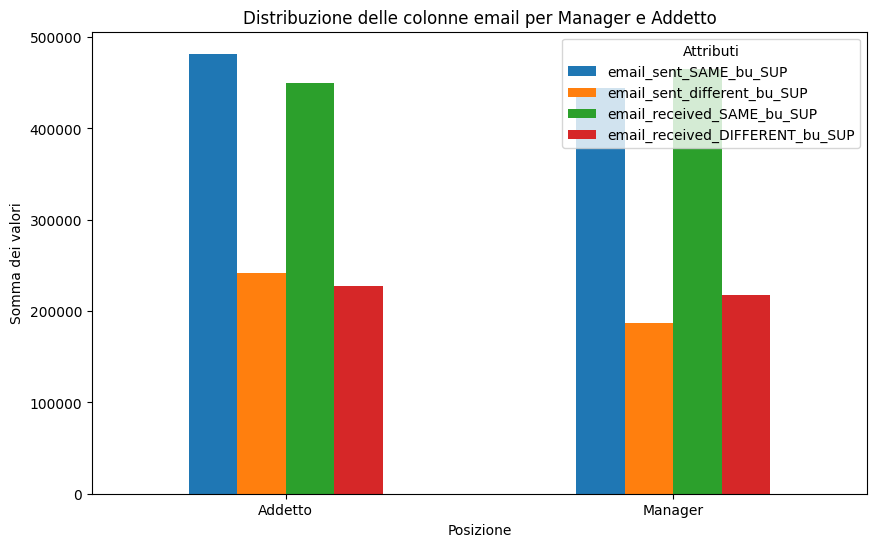

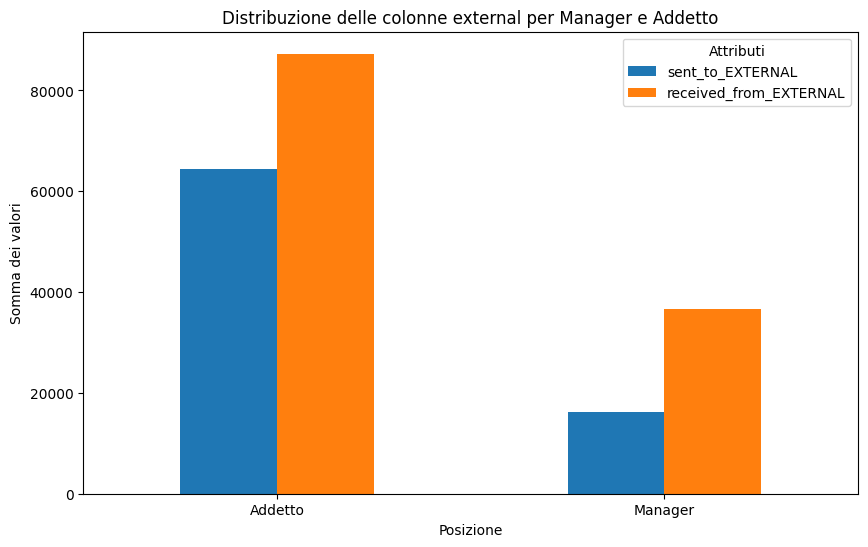

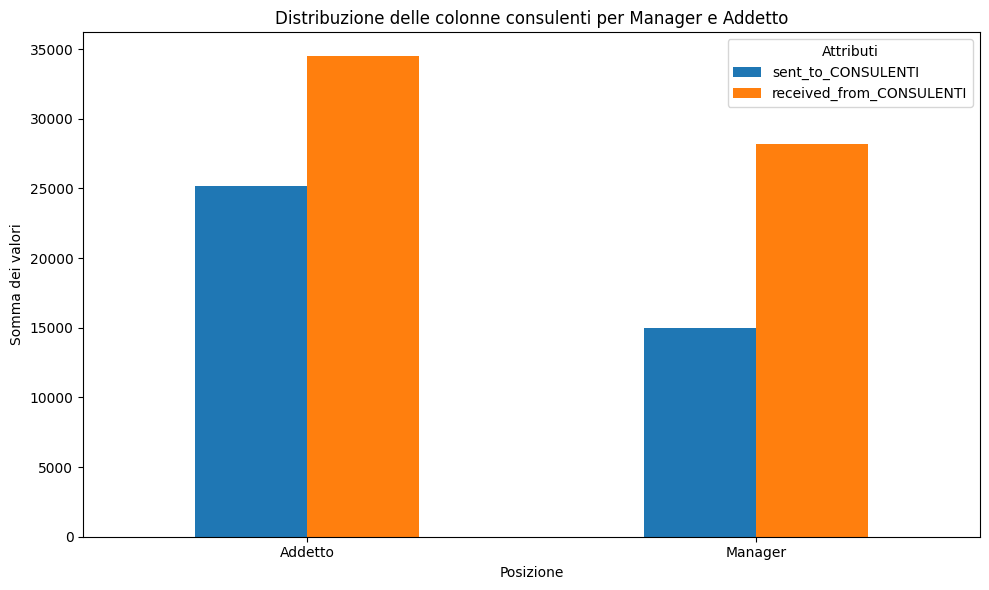

In [ ]:
# Seleziona le colonne per i diversi grafici
columns_email = ['email_sent_SAME_bu_SUP', 'email_sent_different_bu_SUP',
                 'email_received_SAME_bu_SUP', 'email_received_DIFFERENT_bu_SUP']

columns_external = ['sent_to_EXTERNAL', 'received_from_EXTERNAL']

columns_consulenti = ['sent_to_CONSULENTI', 'received_from_CONSULENTI']

# Grafico 1 - Email
aggregated_email_df = result_df.groupby('Posizione')[columns_email].sum()
ax1 = aggregated_email_df.plot(kind='bar', figsize=(10, 6))
ax1.set_xlabel('Posizione')
ax1.set_ylabel('Somma dei valori')
ax1.set_title('Distribuzione delle colonne email per Manager e Addetto')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
ax1.legend(title='Attributi')

# Grafico 2 - External
aggregated_external_df = result_df.groupby('Posizione')[columns_external].sum()
ax2 = aggregated_external_df.plot(kind='bar', figsize=(10, 6))
ax2.set_xlabel('Posizione')
ax2.set_ylabel('Somma dei valori')
ax2.set_title('Distribuzione delle colonne external per Manager e Addetto')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.legend(title='Attributi')

# Grafico 3 - Consulenti
aggregated_consulenti_df = result_df.groupby('Posizione')[columns_consulenti].sum()
ax3 = aggregated_consulenti_df.plot(kind='bar', figsize=(10, 6))
ax3.set_xlabel('Posizione')
ax3.set_ylabel('Somma dei valori')
ax3.set_title('Distribuzione delle colonne consulenti per Manager e Addetto')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(title='Attributi')

plt.tight_layout()
plt.show()

In [ ]:
############################################## Top 10 roles for communication with the EXTERNAL ####################################################


result_df['Total_EXTERNAL'] = result_df['sent_to_EXTERNAL'] + result_df['received_from_EXTERNAL']

# Raggruppa i dati in base a diverse colonne e calcola le somme
pivot_table = result_df.groupby(['Descrizione ruolo', 'Posizione'])['Total_EXTERNAL'].sum().reset_index()

# Ordina la tabella pivot in base alla colonna 'Total_EXTERNAL' in ordine decrescente
pivot_table_sorted = pivot_table.sort_values(by='Total_EXTERNAL', ascending=False)

print(pivot_table_sorted.head(10).to_string())


                              Descrizione ruolo Posizione  Total_EXTERNAL
29                    EXPASS - EXPERT ASSURANCE   Addetto           17859
7                        CL - COMPETENCE LEADER   Addetto           16330
97                RDF - RESPONSABILE DI FILIALE   Manager           12434
111               SPEASS - SPECIALIST ASSURANCE   Addetto           11586
5            BACK - BACK OFFICE UFFICI CENTRALI   Addetto           10620
50                    JUNASS - JUNIOR ASSURANCE   Addetto            6721
31                       EXPAVV - EXPERT AVVERA   Addetto            6282
26    EXPALS - EXPERT AFFARI LEGALI E SOCIETARI   Addetto            6001
0    AGBEFI - ASSISTANT GESTORE DELLA RELAZIONE   Addetto            5501
87           MANSEC - MANAGER SERVIZI CONDIVISI   Manager            4770


In [ ]:
############################################## Top 10 roles for communication with the CONSULENTI ####################################################


result_df['Total_CONSULENTI'] = result_df['sent_to_CONSULENTI'] + result_df['received_from_CONSULENTI']

# Raggruppa i dati in base a diverse colonne e calcola le somme
pivot_table = result_df.groupby(['Descrizione ruolo', 'Posizione'])['Total_CONSULENTI'].sum().reset_index()

# Ordina la tabella pivot in base alla colonna 'Total_CONSULENTI' in ordine decrescente
pivot_table_sorted = pivot_table.sort_values(by='Total_CONSULENTI', ascending=False)

print(pivot_table_sorted.head(10).to_string())


                                    Descrizione ruolo Posizione  Total_CONSULENTI
7                              CL - COMPETENCE LEADER   Addetto             34509
97                      RDF - RESPONSABILE DI FILIALE   Manager             25345
65     MABEOP - MANAGER BANCA EUROMOBILIARE OPERATIVO   Manager              6057
52                             JUNAVV - JUNIOR AVVERA   Addetto              5848
66               MABEPF - MANAGER B.E. COMMERCIALE PF   Manager              3702
0          AGBEFI - ASSISTANT GESTORE DELLA RELAZIONE   Addetto              3651
105       SPBEIC - SPECIALIST B. E. INVESTMENT CENTER   Addetto              3522
13                         CMR - MARKET LEADER RETAIL   Manager              2685
20     EXBEMK - PROF. EXPERT BANCA EUROMOB. MARKETING   Addetto              2197
64   MABENE - MANAGER B.E. NEGOZIAZIONE MIDDLE OFFICE   Manager              1020


In [ ]:
"""
Possiamo quindi vedere che sono gli addetti che inviano verso l'esterno perché i ruoli che inviano di più sono:
                              Descrizione ruolo Posizione  Total_EXTERNAL
29                    EXPASS - EXPERT ASSURANCE   Addetto           17859
7                        CL - COMPETENCE LEADER   Addetto           16330
97                RDF - RESPONSABILE DI FILIALE   Manager           12434
111               SPEASS - SPECIALIST ASSURANCE   Addetto           11586
5            BACK - BACK OFFICE UFFICI CENTRALI   Addetto           10620
50                    JUNASS - JUNIOR ASSURANCE   Addetto            6721
31                       EXPAVV - EXPERT AVVERA   Addetto            6282
26    EXPALS - EXPERT AFFARI LEGALI E SOCIETARI   Addetto            6001
0    AGBEFI - ASSISTANT GESTORE DELLA RELAZIONE   Addetto            5501
87           MANSEC - MANAGER SERVIZI CONDIVISI   Manager            4770

Vediamo quindi che sono figure ricoperte dagli addetti che comunicano con l'esterno.



Mentre per quanto riguarda le interazioni con i consulenti sono abbastanza bilanciate tra Addetti e Manager

                                    Descrizione ruolo Posizione  Total_CONSULENTI
7                              CL - COMPETENCE LEADER   Addetto             34509
97                      RDF - RESPONSABILE DI FILIALE   Manager             25345
65     MABEOP - MANAGER BANCA EUROMOBILIARE OPERATIVO   Manager              6057
52                             JUNAVV - JUNIOR AVVERA   Addetto              5848
66               MABEPF - MANAGER B.E. COMMERCIALE PF   Manager              3702
0          AGBEFI - ASSISTANT GESTORE DELLA RELAZIONE   Addetto              3651
105       SPBEIC - SPECIALIST B. E. INVESTMENT CENTER   Addetto              3522
13                         CMR - MARKET LEADER RETAIL   Manager              2685
20     EXBEMK - PROF. EXPERT BANCA EUROMOB. MARKETING   Addetto              2197
64   MABENE - MANAGER B.E. NEGOZIAZIONE MIDDLE OFFICE   Manager              1020



"""

In [ ]:

"""

A questo punto fai vedere le heatmapGEM e la sankey map, e spiega che le persone comunicano principalemente all'interno della propria BU.

Però, come si vede dai grafici della dashboard dove plotto: total sent, sent same BU, sent different BU,  e l'altro
Il Vedo che la il trend email ricevute ed inviate da BU different è costellato da picchi,
questo potrebbe significare che ci sono delle persone che operano come bridge, comunicando anche con altre BU/community

E quindi che ci potrebbero essere delle persone all'interno di CREDEM che operano come bridge....

=====> ancora un volta il risultato che le comunicazioni sono interne all BU ritorna....


In [ ]:
#INFLUENZA
#chi sono le persone più influenti all’interno di credem?
#Cioè, chi sono le persone che vengono raggiunte maggiormente?

# Ottieni le prime 100 persone con il valore più alto in 'influenceIndex'
top_influence = df_features.nlargest(100, 'influenceIndex')['user_ID']
top_influence= pd.DataFrame(top_influence)

top_influence = top_influence.merge(df_anagrafici_excel[['CODICI RISPONDENTI', 'Posizione']], left_on='user_ID', right_on='CODICI RISPONDENTI', how='left')
top_influence.drop('CODICI RISPONDENTI', axis=1, inplace=True)

top_influence = top_influence.merge(df_anagrafici_excel[['CODICI RISPONDENTI', 'Descrizione ruolo']], left_on='user_ID', right_on='CODICI RISPONDENTI', how='left')
top_influence.drop('CODICI RISPONDENTI', axis=1, inplace=True)



print(pd.pivot_table(top_influence, index=['Descrizione ruolo', 'Posizione'], values=['user_ID'], aggfunc=[np.count_nonzero]).sort_values(by=('count_nonzero', 'user_ID'), ascending=False).to_string())


                                                             count_nonzero
                                                                   user_ID
Descrizione ruolo                                  Posizione              
JUNPEO - JUNIOR PEOPLE MNGT                        Addetto               8
JUNRET - JUNIOR BANKING COMM.LE                    Addetto               8
EXPRET - EXPERT BANKING COMM.LE                    Addetto               8
EXPALS - EXPERT AFFARI LEGALI E SOCIETARI          Addetto               7
SPERET - SPECIALIST BANKING COMM.LE                Addetto               5
EXPPEO - EXPERT PEOPLE MNGT                        Addetto               5
SPEAMM - SPECIALIST AMMINISTRAZIONE                Addetto               4
MANRET - MANAGER BANKING COMM.LE                   Manager               4
JUNSEC - JUNIOR SERVIZI CONDIVISI                  Addetto               3
EXPCOM - EXPERT COMPLIANCE E/O ANTIRICICLAGGIO     Addetto               3
EXPAMM - PROF. EXPERT AMM

In [ ]:
#INFLUENZA
#chi sono le persone più influenti all’interno di credem?
#Cioè, chi sono le persone che vengono raggiunte maggiormente?

# Ottieni le prime 100 persone con il valore più alto in 'influenceIndex'
top_influence = df_features.nlargest(100, 'influenceIndex')['user_ID']

# Fai l'intersezione tra la lista di 'manager_intersection' e 'addetto_intersection'
combined_intersection = set(manager_intersection).union(addetto_intersection)

# Fai l'intersezione tra 'top_influence' e 'combined_intersection'
final_intersection = top_influence[top_influence.isin(combined_intersection)]

# Inizializza il conteggio per 'Descrizione ruolo'
ruolo_counts = {}

# Stampa le persone nell'intersezione finale e conteggio per 'Descrizione ruolo'
print("Final Intersection:", len(final_intersection))
for user_id in final_intersection:
    matching_row = df_anagrafici_excel[df_anagrafici_excel['CODICI RISPONDENTI'] == user_id]
    if not matching_row.empty:
        posizione = matching_row['Posizione'].iloc[0]
        descrizione_ruolo = matching_row['Descrizione ruolo'].iloc[0]
        uo_sup = matching_row['UO sup'].iloc[0]

        # Aggiorna il conteggio per 'Descrizione ruolo'
        if descrizione_ruolo in ruolo_counts:
            ruolo_counts[descrizione_ruolo] += 1
        else:
            ruolo_counts[descrizione_ruolo] = 1

        print(f"User ID: {user_id}, Posizione: {posizione}, Descrizione ruolo: {descrizione_ruolo}, UO sup: {uo_sup}")

# Stampa il conteggio delle persone per ciascuna 'Descrizione ruolo'
print("\nConteggio per Descrizione ruolo:")
sorted_ruolo_counts = sorted(ruolo_counts.items(), key=lambda x: x[1], reverse=True)
for ruolo, count in sorted_ruolo_counts:
    print(f"{ruolo}: {count}")


Final Intersection: 44
User ID: 6sbupT7jSJ2KmmcOGoJZGA, Posizione: Addetto, Descrizione ruolo: EXPPEO - EXPERT PEOPLE MNGT, UO sup: PEOPLE
User ID: pBQdxZTqTAm5oZVFYQU-_g, Posizione: Addetto, Descrizione ruolo: EXPCOM - EXPERT COMPLIANCE E/O ANTIRICICLAGGIO, UO sup: TUTELA
User ID: 51yCSnsPRyG7t7V23TM_0Q, Posizione: Addetto, Descrizione ruolo: JUNPEO - JUNIOR PEOPLE MNGT, UO sup: PEOPLE
User ID: unCUemj7R4S63wIzMoWhCQ, Posizione: Addetto, Descrizione ruolo: EXPALS - EXPERT AFFARI LEGALI E SOCIETARI, UO sup: LEGAL
User ID: jEEgziptTkuVweHV1Qh1MQ, Posizione: Addetto, Descrizione ruolo: JUNPEO - JUNIOR PEOPLE MNGT, UO sup: PEOPLE
User ID: LxCuGT-_SuuNqbP3eUaq_g, Posizione: Addetto, Descrizione ruolo: EXPALS - EXPERT AFFARI LEGALI E SOCIETARI, UO sup: LEGAL
User ID: HMM-OO5nQ3Kk16I0FiOyQA, Posizione: Addetto, Descrizione ruolo: EXPALS - EXPERT AFFARI LEGALI E SOCIETARI, UO sup: LEGAL
User ID: h46uRGf2Sgm02TbH3bL9SQ, Posizione: Addetto, Descrizione ruolo: EXPASS - EXPERT ASSURANCE, UO sup: 

In [ ]:
"""
Dall'analisi di influenza possiamo vedere che all'interno di Credem le persone più influenti sono:
- i ruoli più influenti sono: XXX
- POWERBI: le BU più influenti sono: XXX
- POWERBI: le Regioni più influenti sono: XXX

Inoltre se andiamo a fare l'intersezione tra le 100 persone influenti e quelle più centrali all'interno delle BU vediamo che questi due gruppi hanno in comune XXX persone

"""

In [ ]:
"""
Bridging – Evaluate information flow: Capture the probability to be on the information flow between two communities.

Helps to identify potential gatekeepers, change agents, or controllers, and to remove bottlenecks.

	a. Identify key bridges and their departments

	b. Analyze the correlation of bridging and influence:
		i. High bridging and high influence may imply a leader
		ii. High bridging and low influence may imply a bottleneck in some cases


Per ottenere i Bridge:

1. CommunityDetection utilizzando Leiden Clustering sulla network > ci garantisce dei cluster che sono fortemente connessi tra di loro e con la modularity ottimizzata all'interno,
2. In particolare utilizzo la versione hierarchical_leiden che mi permette di definire una grandezza massima di un cluster per poi andare a splittarlo se raggiunta (100 nel mio caso)
3. Ottengo 63 clusters (molto buono visto che abbiamo 64 BU) >>> questo risultato conferma ancor auna volta il fatto che le persone parlano all'interno delle BU
4. Una volta ottenute le comunity andiamo ad individuare le persone "Bridge", cioé le persone che appartengono ad una comunity ma conversano con quelle di altre:
   Per ogni nodo, contiamo il numero di comunity C con cui il nodo parla (in the sense that given A, I count how many distinct communities are present in the nodes attached to A),
   Normalizzo questo numero dividendolo per il numero totale di comunity (questo ci permette di avere un indice):
   # For all users, compute C / (num of Communities)
   # 1 = they are connected to all communities
   # 0 = they have no connections

"""

'\nBridging – Evaluate information flow: Capture the probability to be on the information flow between two communities. \n\nHelps to identify potential gatekeepers, change agents, or controllers, and to remove bottlenecks.\n\n\ta. Identify key bridges and their departments\n\n\tb. Analyze the correlation of bridging and influence: \n\t\ti. High bridging and high influence may imply a leader\n\t\tii. High bridging and low influence may imply a bottleneck in some cases \n\n\nPer ottenere i Bridge:\n\n1. CommunityDetection utilizzando Leiden Clustering sulla network > ci garantisce dei cluster che sono fortemente connessi tra di loro e con la modularity ottimizzata all\'interno, \n2. In particolare utilizzo la versione hierarchical_leiden che mi permette di definire una grandezza massima di un cluster per poi andare a splittarlo se raggiunta (100 nel mio caso)\n3. Ottengo 63 clusters (molto buono visto che abbiamo 64 BU) >>> questo risultato conferma ancor auna volta il fatto che le perso

In [ ]:
# Mediazione
# utilizza i Bridge index
#Sono coinvolti in scambi tra gruppi diversi? Agiscono come ponti tra reparti o team separati?


# Ottieni le prime 100 persone con il valore più alto in 'influenceIndex'
top_bridge = df_features.nlargest(100, 'CommunityBridgeIndex')['user_ID']

# Fai l'intersezione tra la lista di 'manager_intersection' e 'addetto_intersection'
combined_intersection = set(manager_intersection).union(addetto_intersection)

# Fai l'intersezione tra 'top_bridge' e 'combined_intersection'
final_intersection = top_bridge[top_bridge.isin(combined_intersection)]

print( len(final_intersection)) # sono le persone: più centrali all'interno della propria BU, più influenti in tutta CREDEM e che hanno anche un ruolo da Bridge tra le varie comunity


#################################################################################################################################################################################################################################

# manca la print delle persone !
# fai un confronto tra combined_intersection ed final_intersectio,
#cioé capisci se le persone più centrali, influenti e che operano come bridge non sono altro che le persone più centrali ed influenti




47


In [ ]:
"""

Tramite la Dashboard di powerBI:
- fai vedere le BU che sono più Bridge all'interno di Credem:

- fai vedere le regioni con Bridge più alto

- fai vedere i ruoli con Bridge index più alto

"""

In [ ]:
"""

ANALLISI BRIDGE VS INFLUENCERS

A questo punto fai vedere il grafico in cui Plotti INfluenceIndex VS BridgeIndex

e spiega che quel grafico ci peremtte di individuare: gatekeepers, leaders, ecc....


"""

In [ ]:
"""

 Trai quindi le conclusioni facendo vedere l'analisi di clustering che ci fa vedere come ci siano dei profili:

1. poco centrali, poco influenti e poco bridge che sono addetti
2. poco centrali, poco influenti e poco bridge che sono manager AAA: però un po' più grandi
3. influenti ecc addetti
4. influenti ecc managert


"""

"\n\n Trai quindi le conclusioni facendo vedere l'analisi di clustering che ci fa vedere come ci siano dei profili:\n\n\n"

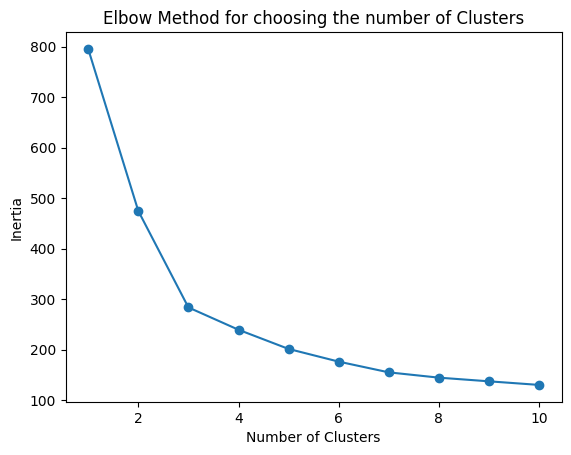

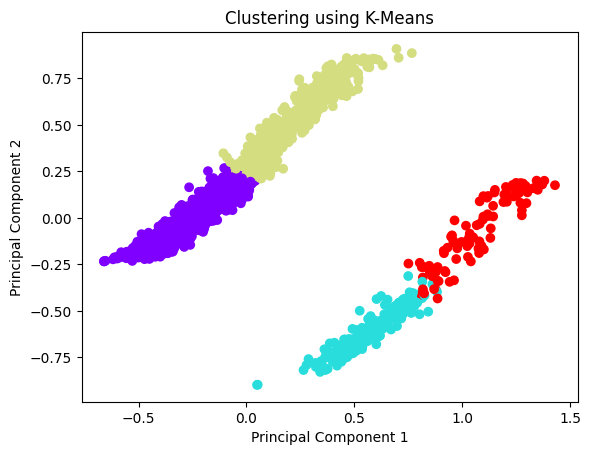

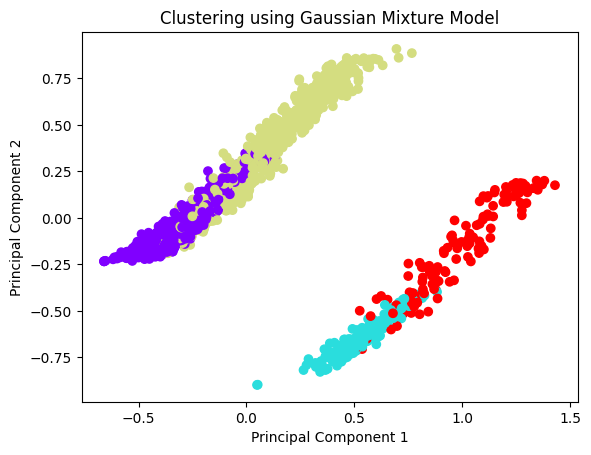

Kappa inter-rater between K-Means e Gaussian Mixture Model: 0.711378696133437
Silhouette Score: 0.48925974837933806
Davies-Bouldin Index: 0.8614712583972761
Calinski-Harabasz Score: 1567.5376222388188


In [ ]:

############################################################################ CLUSTERING ###########################################################################
# concludo l'analisi precedente andando a fare un'analisi di clustering cosìd identificare i profili comunicativi all'interno di CREDEM


#  Feature centralità + mediazione + influenza + addetto vs manager
selected_features = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU', 'CommunityBridgeIndex', 'influenceIndex'  ,'addettoVSmanager']
df_selected = df_features[selected_features]


#max_closeness = df_selected['closeness_BU'].max()
#df_selected['closeness_BU']= (df_selected['closeness_BU']*max_closeness)

# Standardizzazione dei dati: il kmeans richiede tutti i dati con la stessa scala, così ogni feature ha lo stesso impatto
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected)

# ELBOW:   metodo del gomito per sceegliere il numero di cluster
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)


# Plot del metodo del gomito
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for choosing the number of Clusters')
plt.show()

# NUMERO DI CLUSTER SCELTI
num_clusters=4

# K-MEAN
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=14)
kmeans.fit(scaled_data)
labels_kmeans = kmeans.labels_



# Test di robustezza tramite confronto con Gaussian Mixture Model
gmm = GaussianMixture(n_components=num_clusters, random_state=14)
gmm.fit(scaled_data)
labels_gmm = gmm.predict(scaled_data)

# Calcolo del Kappa inter-rater: un valore >0.6 è buono
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(kmeans.labels_, labels_gmm)

# Visualizzazione con PCA: plotto le due componenti principali
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering using K-Means')
plt.show()

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels_gmm, cmap='rainbow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering using Gaussian Mixture Model')
plt.show()




################# Valutazione cluster
silhouette_avg = silhouette_score(scaled_data, labels_kmeans)
db_index = davies_bouldin_score(scaled_data, labels_kmeans)
ch_score = calinski_harabasz_score(scaled_data, labels_kmeans)
print("Kappa inter-rater between K-Means e Gaussian Mixture Model:", kappa)
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", db_index)
print("Calinski-Harabasz Score:", ch_score)

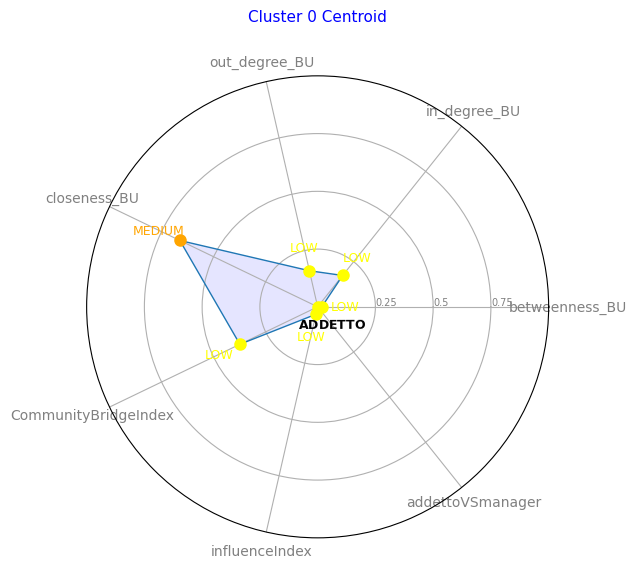

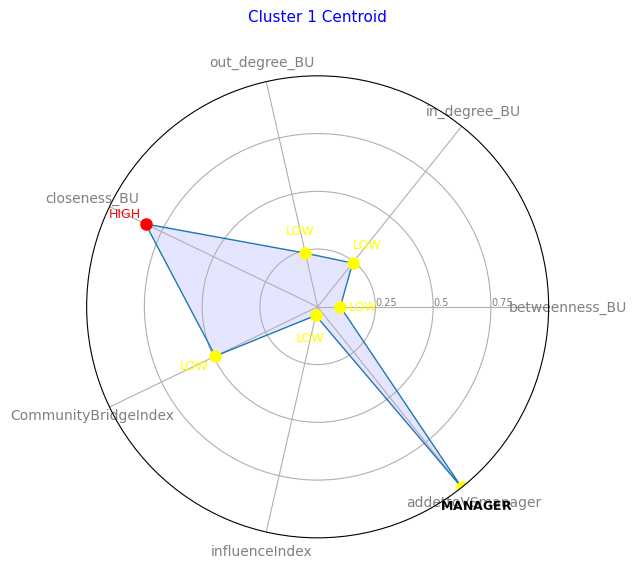

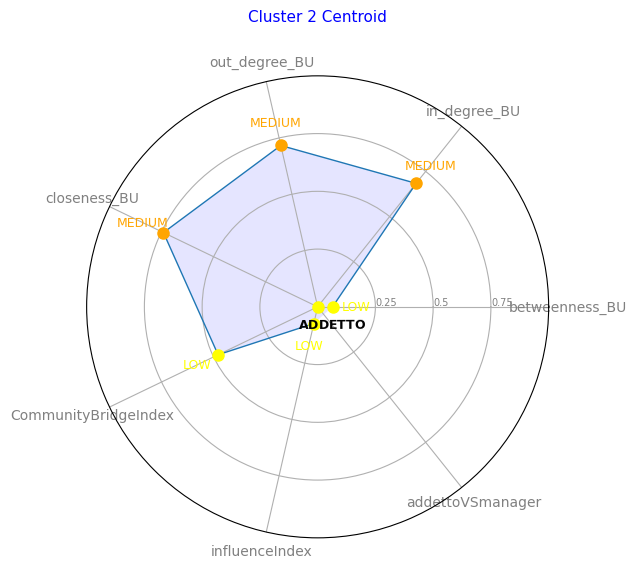

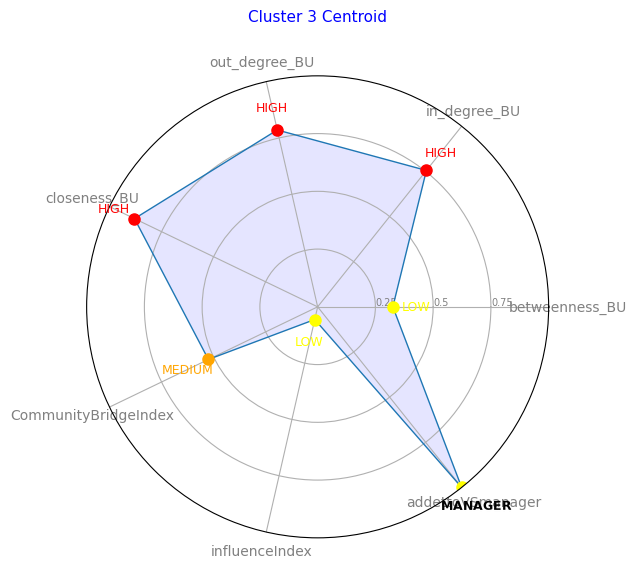

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

cluster_centroids = kmeans.cluster_centers_

# Plot radar charts for cluster means
for i in range(num_clusters):
    plt.figure(figsize=(8, 6))
    categories = list(df_selected.columns)
    values = cluster_centroids[i]
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Duplicate the last value to close the plot
    values = np.concatenate((values, [values[0]]))
    angles += [angles[0]]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)
    plt.plot(angles, values, linewidth=1, linestyle='solid')
    plt.fill(angles, values, 'b', alpha=0.1)

    # Adding a colored dot for each feature
    for j, angle in enumerate(angles[:-1]):
        value = values[j]
        if categories[j] == "addettoVSmanager":
            if abs(value) < 0.0001:
                marker_label = r"$\bf{ADDETTO}$"  # Bold and black label
                value = 0.00001  # Set value to 0 for the marker
            else:
                marker_label = r"$\bf{MANAGER}$"  # Bold and black label
            label_radius = value + 0.1  # Move label slightly outward
            label_color = 'black'
        else:
            if value < 0.5:
                marker_label = "LOW"
                marker_color = 'yellow'
            elif value < 0.75:
                marker_label = "MEDIUM"
                marker_color = 'orange'
            else:
                marker_label = "HIGH"
                marker_color = 'red'
            label_radius = value + 0.1  # Move label slightly outward
            label_color = marker_color
        ax.plot(angle, value, marker='o', color=marker_color, markersize=8)
        angle_adjustment = np.deg2rad(10)  # Adjusting the angle of text placement
        ax.text(angle, label_radius, marker_label, color=label_color, fontsize=9, ha='center', va='center', rotation=angle_adjustment)

    plt.title(f'Cluster {i} Centroid', size=11, color='blue', y=1.1)
    plt.show()


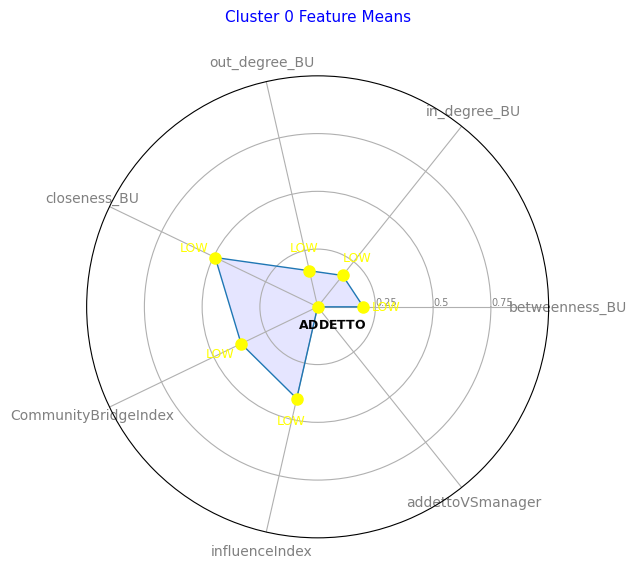

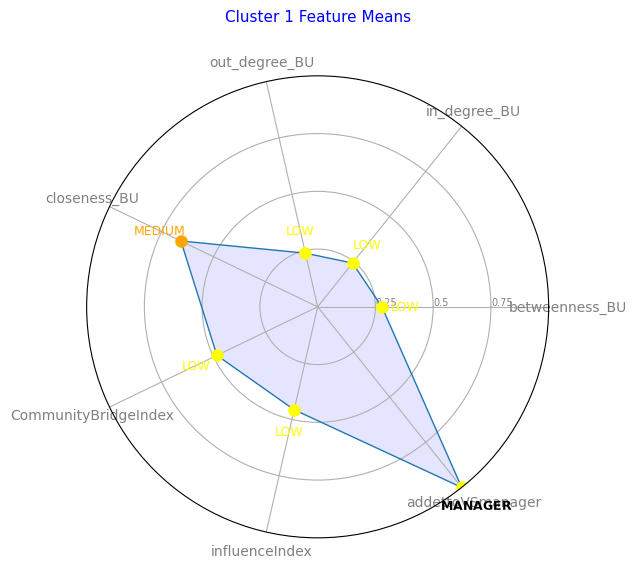

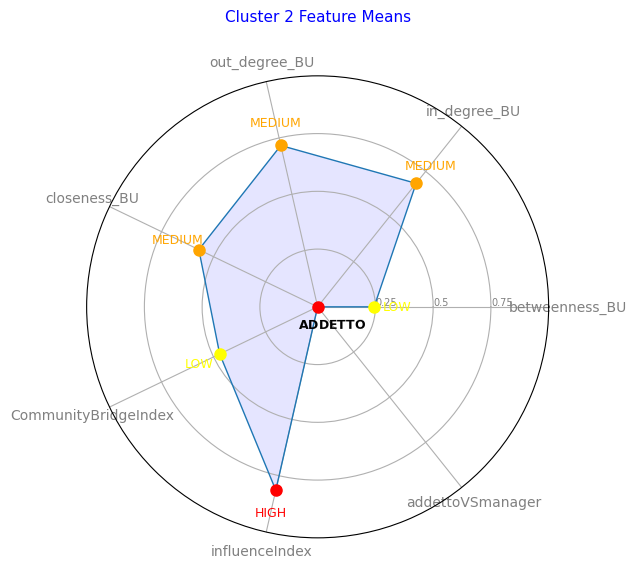

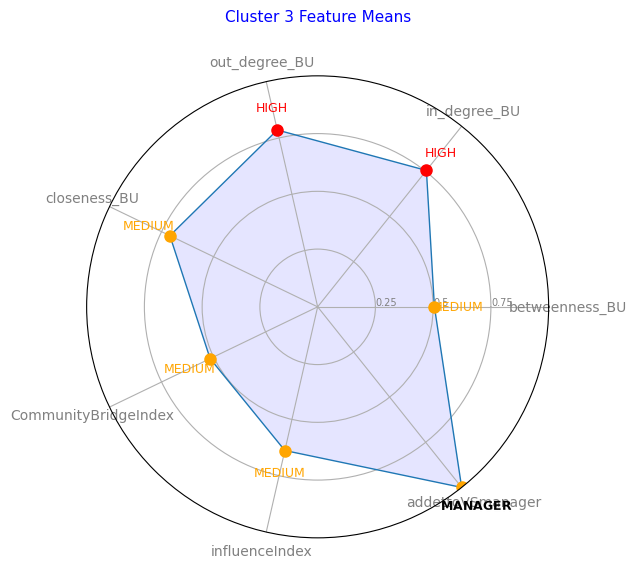

In [ ]:
"""
In our radar chart visualization featuring selected attributes like betweenness_BU, closeness_BU, influenceIndex, etc., specific adjustments were implemented to enhance visual clarity. Notably, closeness was slightly decreased by 0.17, influence index was amplified tenfold, and betweenness centrality was slightly increased by 0.18. These modifications were crucial due to the significantly lower original values of these features, which hindered their effective visualization on a uniform scale. Our primary objective was to ensure all features are equally visible and comparable on the radar chart, which is pivotal for illustrating relative differences.

To uphold transparency and ethical standards in data presentation, these alterations are clearly indicated in both the visualization and the accompanying explanatory materials. We emphasize that such adjustments are made purely for visual clarity and do not alter the actual data values. This clear labeling is a deliberate step to prevent any misinterpretation of the data, ensuring that the viewers understand the context and rationale behind these visual modifications.


"""


cluster_means = df_selected.groupby(labels_kmeans).mean()


#selected_features = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU', 'CommunityBridgeIndex', 'influenceIndex'  ,'addettoVSmanager']

# Plot radar charts for cluster means
for i in range(num_clusters):
    plt.figure(figsize=(8, 6))
    categories = list(df_selected.columns)
    values = cluster_means.loc[i, :].values
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values[3] -= 0.17 # closeness
    values[5] *= 10 # influence
    values[0] += 0.18 #betweenness
    values = np.concatenate((values, [values[0]]))  # Close the plot
    angles += angles[:1]  # Close the plot
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)
    plt.plot(angles, values, linewidth=1, linestyle='solid')
    plt.fill(angles, values, 'b', alpha=0.1)

    # Adding a colored dot for each feature
    for j, angle in enumerate(angles[:-1]):
        value = values[j]
        if categories[j] == "addettoVSmanager":
            if value == 0:
                marker_label = r"$\bf{ADDETTO}$"  # Bold and black label
            else:
                marker_label = r"$\bf{MANAGER}$"  # Bold and black label
            label_radius = value + 0.1  # Move label slightly outward
            label_color = 'black'
        else:
            if value < 0.5:
                marker_label = "LOW"
                marker_color = 'yellow'
            elif value < 0.75:
                marker_label = "MEDIUM"
                marker_color = 'orange'
            else:
                marker_label = "HIGH"
                marker_color = 'red'
            label_radius = value + 0.1  # Move label slightly outward
            label_color = marker_color
        ax.plot(angle, value, marker='o', color=marker_color, markersize=8)
        angle_adjustment = np.deg2rad(10)  # Adjusting the angle of text placement
        ax.text(angle, label_radius, marker_label, color=label_color, fontsize=9, ha='center', va='center', rotation=angle_adjustment)

    plt.title(f'Cluster {i} Feature Means', size=11, color='blue', y=1.1)
    plt.show()


In [ ]:
"""
Clustering 1 - Profilo Addetti con Valori Bassi:
In questo caso, sembra che gli addetti in questo cluster abbiano una bassa interazione
 non solo con altre Business Unit, ma anche all'interno della loro stessa Business Unit.
Ciò potrebbe indicare che i membri di questo cluster non sono particolarmente centrali nella rete
e potrebbero avere un ruolo più periferico nelle dinamiche di comunicazione.
Questa situazione potrebbe riflettere ruoli specialistici all'interno dell'unità,
 dove le interazioni sono focalizzate sulla risoluzione di problemi specifici
 o attività specializzate.
Questi individui potrebbero essere coinvolti principalmente in compiti operativi
 piuttosto che in decisioni strategiche o coordinamento a livello aziendale.

Clustering 2 - Profilo Manager con Valori Medio-Bassi e Closeness Alto:
Questo cluster suggerisce che i manager delle Business Unit
hanno una moderata interazione interna alla loro unità,
 ma la loro vicinanza elevata indica che sono ben posizionati
 per comunicare rapidamente con altri membri della loro unità.
 Questo può riflettere un ruolo di coordinamento all'interno dell'unità stessa.
 Poiché sono manager, potrebbero avere responsabilità di gestione e decisioni
  che richiedono la capacità di scambiare informazioni tra membri
   della stessa Business Unit.

Clustering 3 - Profilo Addetti con Valori Misti:
Questo cluster sembra rappresentare addetti che potrebbero avere
un ruolo unico all'interno delle loro Business Unit.
 La mancanza di rilevanza nella misura di "betweenness" e "CommunityBridgeIndex"
  suggerisce che non fungono da collegamenti tra le unità,
   ma il loro alto "influenceIndex" indica che possono esercitare
   un'influenza significativa sui colleghi.
Potrebbero essere considerati esperti o figure di riferimento all'interno
delle loro Business Unit, contribuendo a decisioni e processi interni.

Clustering 4 - Profilo Manager con Valori Alti di In-Degree e Out-Degree:
Questo cluster rappresenta chiaramente manager chiave dell'azienda.
L'alto "in-degree" e "out-degree" indicano che sono coinvolti in numerose interazioni
sia all'interno della loro Business Unit che con altre Business Unit.
La loro posizione centrale nella rete, misurata attraverso la "betweenness",
suggerisce che agiscono come mediatori o punti di riferimento anche all'interno
della Business Unit.
 L'influenza derivante da queste numerose connessioni li rende figure cruciali
 per la diffusione delle informazioni e la coordinazione
 tra diverse parti dell'azienda.


"""

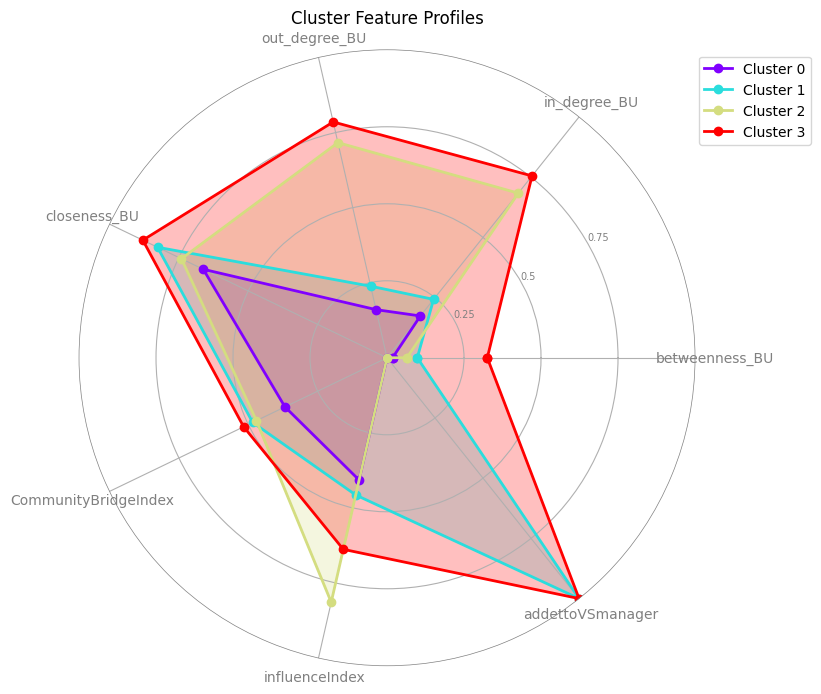

In [ ]:
# Calculate cluster means for selected features
cluster_means = df_selected.groupby(labels_kmeans).mean()

# Create a color map for clusters
colors = plt.cm.rainbow(np.linspace(0, 1, num_clusters))

# Plot spider maps for cluster means
categories = list(df_selected.columns)
num_categories = len(categories)

angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False).tolist()
angles += angles[:1]  # Close the plot

plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)

for i in range(num_clusters):
    values = cluster_means.loc[i, :].values
    # Multiply influenceIndex by 10 to scale it properly
    values[5] *= 10  # Assuming influenceIndex is at index 5
    values = np.concatenate((values, [values[0]]))  # Close the plot
    ax.plot(angles, values, color=colors[i], marker='o', label=f'Cluster {i}', linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.set_rlabel_position(30)

# Set radial axes and labels
plt.xticks(angles[:-1], categories, color='grey', size=10)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
plt.ylim(0, 1)

# Draw spokes
ax.spines['polar'].set_color('grey')
ax.spines['polar'].set_linewidth(0.5)

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title("Cluster Feature Profiles")
plt.show()


In [ ]:




##################################### CLASSIFICAZIONE DELLE PERFORMANCE in base ai pattern comunicativi ############################àà



"""


//////////////////////////////////////////////////////////////////////// CLASSIFICAZIONE DELLE PERFORMANCE!!! \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\



"""





In [ ]:
# OUTLIER REMOVAL

from sklearn.linear_model import LinearRegression

#SECONDO

df_features_TEMP = df_features[(df_features['total_sent_email']<25000) & (df_features['total_received_email']<35000)]
df_features_TEMP = df_features_TEMP[(df_features_TEMP['total_sent_email']>100) & (df_features_TEMP['total_received_email']>100)]




# Linear regression
X = df_features_TEMP[['total_sent_email']]
y = df_features_TEMP['total_received_email']
model = LinearRegression()
model.fit(X, y)

# Predict and calculate percentage error
df_features_TEMP['predicted'] = model.predict(X)
#df_features_TEMP['percentage_error'] = np.abs((df_features_TEMP['total_received_email'] - df_features_TEMP['predicted']) / df_features_TEMP['total_received_email']) * 100
df_features_TEMP['percentage_error'] = np.abs((df_features_TEMP['total_received_email'] - df_features_TEMP['predicted']) / df_features_TEMP['predicted']) * 100


# Define thresholds (e.g., 15% error)
error_threshold = 55  # You can adjust this threshold

# Filter data based on the threshold
df_features_clean_corr = df_features_TEMP[df_features_TEMP['percentage_error'] <= error_threshold]


#TERZO

### OUTLIER IQR REMOVE

#df_features_clean = df_features_clean_corr[df_features_clean_corr['out_degree_BU']<0.99] # utilizzare la out degree per pulire e' giustificbile sempre per le stesse ragioni delle email in broadcast ell'inizio!!
df_features_clean = df_features_clean_corr[df_features_clean_corr['closeness_BU']>0.0000000001] # per eliminare i nodi isolati

df_features_clean = df_features_clean[df_features_clean['out_degree_BU']>0.0000000001]
df_features_clean = df_features_clean[df_features_clean['in_degree_BU']>0.0000000001]

#df_features_clean = df_features_clean[df_features_clean['betweenness_BU']<0.5]
#df_features_clean = df_features_clean[df_features_clean['influenceIndex']<0.2]

df_features_clean = df_features_clean[df_features_clean['contribution_index']> -0.97]

#df_features_clean = df_features_clean[df_features_clean['total_sent_email']<20000] #20 000
#df_features_clean = df_features_clean[df_features_clean['total_received_email']<35000] # 35 000
#df_features_clean = df_features_clean[df_features_clean['total_SAME_bu_SUP']<8000]

df_features_clean = df_features_clean[df_features_clean['people_total_SAME_bu_SUP']<50]
df_features_clean = df_features_clean[df_features_clean['#persone_interazioni']<150]





#df_features_clean = df_features_clean[df_features_clean['total_sent_email']>1]
#df_features_clean = df_features_clean[df_features_clean['total_received_email']>1]

print(len(df_features))
print(len(df_features_clean_corr))
print(len(df_features_clean))

X_columns = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU', 'CommunityBridgeIndex', 'influenceIndex'  ,'addettoVSmanager']  #TOP


X = df_features_clean[X_columns] # I'm passing the names of the column of the original dataframe of which i want to keep the columns
Y = df_features_clean['WE_average'] #TARGET OF THE REGRESSION

# Normalizzazione delle variabili indipendenti
scaler = MinMaxScaler()

df_features_clean[X_columns] = scaler.fit_transform(df_features_clean[X_columns])

df_features=df_features_clean

2027
1545
1485


7.0    730
6.0    941
5.0    220
4.0     42
3.0     24
2.0      4
1.0      5
Name: performance, dtype: int64


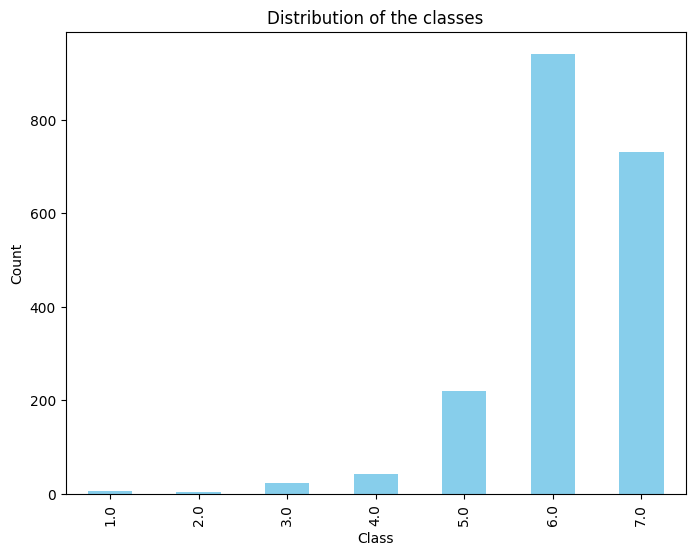

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks


df_features_filtered= df_features[ df_features['performance']!=0]
#df_features_filtered= df_features[ df_features['performance']>3]


selected_features = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU', 'CommunityBridgeIndex', 'influenceIndex'  ,'addettoVSmanager']  #TOP

X = df_features_filtered[selected_features]
Y = df_features_filtered['performance']


class_counts = Y.value_counts().sort_index(ascending=False)


print(class_counts)


class_counts = Y.value_counts().sort_index(ascending=True)
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of the classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
import matplotlib.pyplot as plt


print("######################### RANDOM FOREST CLASSIFIER: dataset sbilanciato e 7 classi  ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

"""
# Define the hyperparameter grid to search through
param_grid = {
    'n_estimators': [ 100, 150, 200, 250],
    'max_depth': [ 9, 10, 11, 12, 13, 14, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None],
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV on your data
grid_search.fit(X_train,  Y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predict using the best model
Y_pred = best_rf_model.predict(X_test)
"""



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=20, min_samples_split= 2, min_samples_leaf= 1 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)


# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""





######################### RANDOM FOREST CLASSIFIER: dataset sbilanciato e 7 classi  ########################
Accuracy on test set (Random Forest): 0.4570446735395189
Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         2
         4.0       0.00      0.00      0.00         7
         5.0       0.57      0.12      0.20        34
         6.0       0.48      0.66      0.55       134
         7.0       0.42      0.36      0.38       112

    accuracy                           0.46       291
   macro avg       0.21      0.16      0.16       291
weighted avg       0.45      0.46      0.43       291

Confusion Matrix:
  Pred_1.0 Pred_2.0 Pred_3.0 Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_1.0 0 0 0 0 0 1 0
True_2.0 0 0 0 0 0 1 0
True_3.0 0 0 0 0 0 0 2
True_4.0 0 0 0 0 0 6 1
True_5.0 0 1 0 0 4 20 9
True_6.0 0 0 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:
"""

I get rid of the classes: 1,2,3 keeping only 4,5,6,7

"""


df_features_filtered= df_features[ df_features['performance']>3.1]


selected_features = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU', 'CommunityBridgeIndex', 'influenceIndex'  ,'addettoVSmanager']  #TOP

X = df_features_filtered[selected_features]
Y = df_features_filtered['performance']


class_counts = Y.value_counts().sort_index(ascending=False)


print(class_counts)


7.0    560
6.0    669
5.0    172
4.0     33
Name: performance, dtype: int64


In [ ]:
import matplotlib.pyplot as plt


print("######################### RANDOM FOREST CLASSIFIER: dataset sbilanciato e 4 classi (4,5,6,7) ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

"""
# Define the hyperparameter grid to search through
param_grid = {
    'n_estimators': [ 100, 150, 200, 250],
    'max_depth': [ 9, 10, 11, 12, 13, 14, 15, 20],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2', None],
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV on your data
grid_search.fit(X_train,  Y_train)

# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Predict using the best model
Y_pred = best_rf_model.predict(X_test)
"""



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=20, min_samples_split= 2, min_samples_leaf= 1 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)


# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""





######################### RANDOM FOREST CLASSIFIER: dataset sbilanciato e 4 classi (4,5,6,7) ########################
Accuracy on test set (Random Forest): 0.47038327526132406
Classification Report:
               precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.50      0.09      0.15        34
         6.0       0.50      0.75      0.60       134
         7.0       0.41      0.29      0.34       112

    accuracy                           0.47       287
   macro avg       0.35      0.28      0.27       287
weighted avg       0.45      0.47      0.43       287

Confusion Matrix:
  Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_4.0 0 0 3 4
True_5.0 0 3 21 10
True_6.0 0 1 100 33
True_7.0 0 2 78 32


Feature: betweenness_BU, Importance: 0.11149913594424098
Feature: in_degree_BU, Importance: 0.1820575813686092
Feature: out_degree_BU, Importance: 0.17335885749124078
Feature: closeness_BU, Importance: 0.17528327363533036
Feature: C

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: OVERSAMPLE con 4 classi SUL TRAINING SET ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)



#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
ros= RandomOverSampler(random_state=43)
#ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)

# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=None, min_samples_split= 4, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: OVERSAMPLE con 4 classi SUL TRAINING SET ########################
Accuracy on test set (Random Forest): 0.39372822299651566
Classification Report:
               precision    recall  f1-score   support

         4.0       0.08      0.14      0.10         7
         5.0       0.09      0.09      0.09        34
         6.0       0.47      0.53      0.50       134
         7.0       0.43      0.34      0.38       112

    accuracy                           0.39       287
   macro avg       0.27      0.28      0.27       287
weighted avg       0.40      0.39      0.39       287

Confusion Matrix:
  Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_4.0 1 4 1 1
True_5.0 1 3 20 10
True_6.0 4 19 71 40
True_7.0 7 8 59 38


Feature: betweenness_BU, Importance: 0.1097919461444463
Feature: in_degree_BU, Importance: 0.1978362685043913
Feature: out_degree_BU, Importance: 0.17668001589369234
Feature: closeness_BU, Importance: 0.16507104851753537
Feature: Co

'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: UNDERSAMPLE con 4 classi SUL TRAINING SET ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)



#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)

# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=None, min_samples_split= 4, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: UNDERSAMPLE con 4 classi SUL TRAINING SET ########################
Accuracy on test set (Random Forest): 0.28222996515679444
Classification Report:
               precision    recall  f1-score   support

         4.0       0.05      0.57      0.10         7
         5.0       0.08      0.15      0.10        34
         6.0       0.52      0.34      0.41       134
         7.0       0.44      0.23      0.30       112

    accuracy                           0.28       287
   macro avg       0.27      0.32      0.23       287
weighted avg       0.42      0.28      0.33       287

Confusion Matrix:
  Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_4.0 4 1 1 1
True_5.0 11 5 11 7
True_6.0 30 33 46 25
True_7.0 32 23 31 26


Feature: betweenness_BU, Importance: 0.11743203051262785
Feature: in_degree_BU, Importance: 0.19294363658618255
Feature: out_degree_BU, Importance: 0.15803447240332422
Feature: closeness_BU, Importance: 0.1453675850446019
Featur

'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: UNDERSAMPLE + OVERSAMPLE con 4 classi SUL TRAINING SET ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)



#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)

ros = RandomOverSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_bal, Y_bal)


# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=None, min_samples_split= 4, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: UNDERSAMPLE + OVERSAMPLE con 4 classi SUL TRAINING SET ########################
Accuracy on test set (Random Forest): 0.28222996515679444
Classification Report:
               precision    recall  f1-score   support

         4.0       0.05      0.57      0.10         7
         5.0       0.08      0.15      0.10        34
         6.0       0.52      0.34      0.41       134
         7.0       0.44      0.23      0.30       112

    accuracy                           0.28       287
   macro avg       0.27      0.32      0.23       287
weighted avg       0.42      0.28      0.33       287

Confusion Matrix:
  Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_4.0 4 1 1 1
True_5.0 11 5 11 7
True_6.0 30 33 46 25
True_7.0 32 23 31 26


Feature: betweenness_BU, Importance: 0.11743203051262785
Feature: in_degree_BU, Importance: 0.19294363658618255
Feature: out_degree_BU, Importance: 0.15803447240332422
Feature: closeness_BU, Importance: 0.1453675850

'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: smoteTomelink con 4 classi SUL TRAINING SET ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)



tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
#ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)

# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=None, min_samples_split= 4, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


# ho diviso il dataset tra training e testing, ho applicato lo SMOTE al training, così lo alleno sui dati sintetici e poi lo testo su quelli reali> questo mi permette di risolvere l'overfitting
rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: smoteTomelink con 4 classi SUL TRAINING SET ########################
Accuracy on test set (Random Forest): 0.3588850174216028
Classification Report:
               precision    recall  f1-score   support

         4.0       0.00      0.00      0.00         7
         5.0       0.12      0.24      0.16        34
         6.0       0.51      0.49      0.50       134
         7.0       0.44      0.26      0.33       112

    accuracy                           0.36       287
   macro avg       0.27      0.25      0.25       287
weighted avg       0.42      0.36      0.38       287

Confusion Matrix:
  Pred_4.0 Pred_5.0 Pred_6.0 Pred_7.0
True_4.0 0 4 1 2
True_5.0 3 8 16 7
True_6.0 9 31 66 28
True_7.0 15 22 46 29


Feature: betweenness_BU, Importance: 0.1315738836377743
Feature: in_degree_BU, Importance: 0.19344394720949576
Feature: out_degree_BU, Importance: 0.1537356134740245
Feature: closeness_BU, Importance: 0.17678999924966707
Feature:

'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""





################################################################# VADO A CREARE 2 BUCKET ANZICHE 4 #####################################################################################





"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

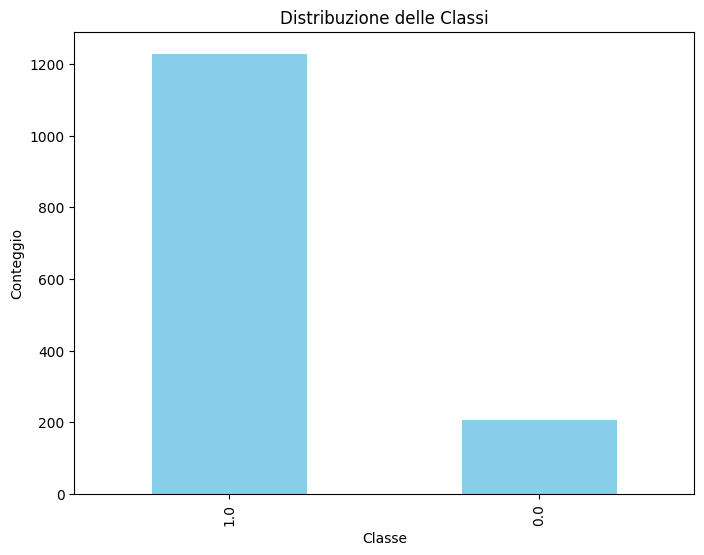

1.0    1229
0.0     205
Name: performance, dtype: int64


In [ ]:

# Sostituisci i valori di 'performance' < 3 con il valore 3, cos' ottengo la classe dei negativi, la classe neutra e quella dei positivi


df_features_filtered.loc[(df_features_filtered['performance'] == 6) | (df_features_filtered['performance'] == 7), 'performance'] = 1
df_features_filtered.loc[(df_features_filtered['performance'] == 4) | (df_features_filtered['performance'] == 5), 'performance'] = 0



selected_features = [ 'betweenness_BU', 'in_degree_BU', 'out_degree_BU' ,'closeness_BU',  'CommunityBridgeIndex', 'influenceIndex','addettoVSmanager']  #TOP

X = df_features_filtered[selected_features]
Y = df_features_filtered['performance']


# Ottieni la distribuzione delle occorrenze delle classi
class_counts = Y.value_counts()

# Plotta la distribuzione
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle Classi')
plt.xlabel('Classe')
plt.ylabel('Conteggio')
plt.show()

print(class_counts)

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: 2CLASSI + SENZA BALANCE ########################")



# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)



#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
#ros = RandomUnderSampler(random_state=43)
#X_bal, Y_bal = ros.fit_resample(X_train, Y_train)

# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=11, min_samples_split= 10, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""


######################### RANDOM FOREST CLASSIFIER: 2CLASSI + SENZA BALANCE ########################
Accuracy on test set (Random Forest): 0.8222996515679443
Classification Report:
               precision    recall  f1-score   support

         0.0       0.22      0.10      0.14        41
         1.0       0.86      0.94      0.90       246

    accuracy                           0.82       287
   macro avg       0.54      0.52      0.52       287
weighted avg       0.77      0.82      0.79       287

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 4 37
True_1.0 14 232


Feature: betweenness_BU, Importance: 0.10500136476294497
Feature: in_degree_BU, Importance: 0.182032342317696
Feature: out_degree_BU, Importance: 0.1765545817813727
Feature: closeness_BU, Importance: 0.16022168492461245
Feature: CommunityBridgeIndex, Importance: 0.15845697105356968
Feature: influenceIndex, Importance: 0.20816220474473346
Feature: addettoVSmanager, Importance: 0.009570850415070683




'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomOverSampler ########################")



# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
ros= RandomOverSampler(random_state=43)
#ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)



# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
#rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=11, min_samples_split= 10, min_samples_leaf= 4 , random_state=43, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=12, min_samples_split= 10, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (RandomOverSampler):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomOverSampler ########################
Accuracy on test set (RandomOverSampler): 0.8048780487804879
Classification Report:
               precision    recall  f1-score   support

         0.0       0.24      0.17      0.20        41
         1.0       0.87      0.91      0.89       246

    accuracy                           0.80       287
   macro avg       0.55      0.54      0.54       287
weighted avg       0.78      0.80      0.79       287

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 7 34
True_1.0 22 224


Feature: betweenness_BU, Importance: 0.10890245587574339
Feature: in_degree_BU, Importance: 0.1747369528374708
Feature: out_degree_BU, Importance: 0.1726333621823683
Feature: closeness_BU, Importance: 0.17111227714044755
Feature: CommunityBridgeIndex, Importance: 0.15909802638639509
Feature: influenceIndex, Importance: 0.20481378968071612
Feature: addettoVSmanager, Importance: 0.008703135896858746




'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomUNDERSampler ########################")



# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)


#tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
#ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)



# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
#rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=11, min_samples_split= 10, min_samples_leaf= 4 , random_state=43, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=250, max_features= 'sqrt', max_depth=12, min_samples_split= 10, min_samples_leaf= 4 , random_state=43, class_weight='balanced')


rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (RandomOverSampler):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomUNDERSampler ########################
Accuracy on test set (RandomOverSampler): 0.5365853658536586
Classification Report:
               precision    recall  f1-score   support

         0.0       0.16      0.51      0.24        41
         1.0       0.87      0.54      0.67       246

    accuracy                           0.54       287
   macro avg       0.51      0.53      0.45       287
weighted avg       0.77      0.54      0.61       287

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 21 20
True_1.0 113 133


Feature: betweenness_BU, Importance: 0.07898983287851799
Feature: in_degree_BU, Importance: 0.1837806005539157
Feature: out_degree_BU, Importance: 0.17406135652702673
Feature: closeness_BU, Importance: 0.14853383092531122
Feature: CommunityBridgeIndex, Importance: 0.18166688994308225
Feature: influenceIndex, Importance: 0.22469478930239578
Feature: addettoVSmanager, Importance: 0.008272699869750445




'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:
print("######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomOverSampler + RandomUnderSampler ########################")


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Initialize RandomOverSampler and RandomUnderSampler
ros = RandomOverSampler(random_state=43)
#ros= SMOTE(random_state=43)
rus = RandomUnderSampler(random_state=43)

# Apply RandomOverSampler followed by RandomUnderSampler
X_over, Y_over = ros.fit_resample(X_train, Y_train)
X_bal, Y_bal = rus.fit_resample(X_over, Y_over)

# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier(n_estimators=250, max_features='sqrt', max_depth=10, min_samples_split=12, min_samples_leaf=4, random_state=43, class_weight='balanced')

rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (RandomOverSampler + RandomUnderSampler):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

# Confusion Matrix
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print("Feature Importance:")
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")


######################### RANDOM FOREST CLASSIFIER: 2 classi + RandomOverSampler + RandomUnderSampler ########################
Accuracy on test set (RandomOverSampler + RandomUnderSampler): 0.794425087108014
Classification Report:
               precision    recall  f1-score   support

         0.0       0.26      0.24      0.25        41
         1.0       0.88      0.89      0.88       246

    accuracy                           0.79       287
   macro avg       0.57      0.57      0.57       287
weighted avg       0.79      0.79      0.79       287

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 10 31
True_1.0 28 218

Feature Importance:
Feature: betweenness_BU, Importance: 0.10291395107907696
Feature: in_degree_BU, Importance: 0.1826238401784778
Feature: out_degree_BU, Importance: 0.17260065535228966
Feature: closeness_BU, Importance: 0.1613600378717007
Feature: CommunityBridgeIndex, Importance: 0.16765386256525328
Feature: influenceIndex, Importance: 0.20501425412633625
Feature: a

In [ ]:

print("######################### RANDOM FOREST CLASSIFIER: smote-tommelink  ########################")


# Split data into training and testing sets
#stratify=Y: Questo è un argomento importante quando si ha uno sbilanciamento tra le classi. Quando è impostato su Y, l'obiettivo è mantenere la stessa distribuzione delle classi sia nel training set che nel test set. Questo è particolarmente utile per garantire che entrambi i set contengano rappresentazioni sufficienti di tutte le classi.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=43, stratify=Y)


tomek =  TomekLinks(sampling_strategy='auto') # VS  RandomUnderSampler per spiegare che è meglio il RandomOverSampler: spiega la storia del rumore introdotto nel caso io inserissi dati sintetici, quindi la miglior cosa da fare è andare a splittare memglio i ldataset togliendo quelli collegati!
ros= SMOTETomek(tomek=tomek, random_state=43)
#ros= tomek
#ros= SMOTE(random_state=43)
#ros= RandomOverSampler(random_state=43)
#ros = RandomUnderSampler(random_state=43)
X_bal, Y_bal = ros.fit_resample(X_train, Y_train)



# dealing with undersample
#SMOTETomek(random_state=43) #RandomUnderSampler(random_state=43)#TOP #SMOTE(random_state=43)  #RandomOverSampler(random_state=43) # TomekLinks(sampling_strategy='auto')



# Initialize the RandomForestRegressor model
#class_weight: Questo argomento assegna pesi alle classi durante l'addestramento. Impostando 'balanced', il modello assegnerà pesi maggiori alle classi minoritarie per bilanciare l'impatto delle classi sbilanciate.
#Best Parameters: {'class_weight': None, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
#Best Parameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
#rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=None, min_samples_split= 2, min_samples_leaf= 4 , random_state=43, class_weight=None)
#rf_model = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=15, min_samples_split=11, min_samples_leaf=8, random_state=43, class_weight='balanced')
#rf_model = RandomForestClassifier(n_estimators=350, max_features= 'sqrt', max_depth=11, min_samples_split= 10, min_samples_leaf= 8 , random_state=43, class_weight='balanced')
#rf_model = RandomForestClassifier(n_estimators=450, max_features='sqrt', max_depth=10, min_samples_split=12, min_samples_leaf=6, random_state=43, class_weight='balanced')
rf_model = RandomForestClassifier(n_estimators=350, max_features='sqrt', max_depth=10, min_samples_split=11, min_samples_leaf=7, random_state=43, class_weight='balanced')


rf_model.fit(X_bal, Y_bal)

Y_pred = rf_model.predict(X_test)

# Print the results
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

#CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

feature_importance = rf_model.feature_importances_
feature_names = X.columns

print()
print()



for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

print()
print()

"""
Precision = Out of all the positive predictions we made, how many were true?
Recall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?
F1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.

"""

######################### RANDOM FOREST CLASSIFIER: smote-tommelink  ########################
Accuracy on test set (Random Forest): 0.6689895470383276
Classification Report:
               precision    recall  f1-score   support

         0.0       0.18      0.37      0.24        82
         1.0       0.87      0.72      0.79       492

    accuracy                           0.67       574
   macro avg       0.53      0.54      0.51       574
weighted avg       0.77      0.67      0.71       574

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 30 52
True_1.0 138 354


Feature: betweenness_BU, Importance: 0.12438269586204513
Feature: in_degree_BU, Importance: 0.1951483756070906
Feature: out_degree_BU, Importance: 0.13840697785362724
Feature: closeness_BU, Importance: 0.15134685521597202
Feature: CommunityBridgeIndex, Importance: 0.1870214602996174
Feature: influenceIndex, Importance: 0.19232374091142898
Feature: addettoVSmanager, Importance: 0.011369894250218667




'\nPrecision = Out of all the positive predictions we made, how many were true?\nRecall  = Out of all the data points that should be predicted as true, how many did we correctly predict as true?\nF1 Score = F1 Score is a measure that combines recall and precision: can therefore be used to measure how effectively our models make that trade-off.\n\n'

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Step 1: Balance the classes using SMOTE-TomekLink
smt = SMOTETomek(random_state=43)
X_bal, Y_bal = smt.fit_resample(X, Y)

# Step 2: Split the dataset into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_bal, Y_bal, test_size=0.4, random_state=43, stratify=Y_bal)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=43, stratify=Y_temp)

# Step 3: Hyperparameter Tuning through Grid Search
param_grid = {
    'n_estimators': [ 150, 250, 350, 500],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': [None, 'balanced']
}

rf_model = RandomForestClassifier(random_state=43)
grid_search = GridSearchCV(rf_model, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
grid_search.fit(X_val, Y_val)

# Get the best hyperparameters from Grid Search
best_rf_model = grid_search.best_estimator_

# Step 4: Evaluate the Model
Y_pred = best_rf_model.predict(X_test)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Accuracy on test set (Random Forest):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

# CONFUSION MATRIX
unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

# Print the confusion matrix with labels on columns
print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

# Feature Importance
feature_importance = best_rf_model.feature_importances_
feature_names = X.columns

print("\nFeature Importance:")
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")


In [ ]:
"""

SMOTE-TomekLink is a technique that combines SMOTE (Synthetic Minority Over-sampling Technique) and Tomek links to address class imbalance in a dataset. When you apply SMOTE-TomekLink to the whole dataset, it's because the combination of SMOTE and Tomek links together ensures that the dataset remains balanced while simultaneously removing potentially problematic instances. Here's why applying it to the whole dataset is appropriate:

SMOTE Oversampling: SMOTE generates synthetic samples for the minority class while preserving the majority class samples. By applying SMOTE to the entire dataset, you ensure that the minority class is appropriately oversampled, which helps prevent it from being underrepresented in both the training and testing sets.

Tomek Link Undersampling: Tomek links are used to identify pairs of instances (one from the majority class and one from the minority class) that are close to each other but belong to different classes. By removing the majority class instances from these pairs, Tomek links help clean the dataset from potentially confusing or noisy samples. Applying Tomek links to the entire dataset ensures that these potentially problematic instances are removed across the entire dataset, benefiting both training and testing.

Balance and Data Quality: The goal of SMOTE-TomekLink is to create a balanced dataset while improving data quality. By applying it to the whole dataset, you maintain the balance and quality of both classes in the entire dataset, making it more representative and less prone to bias.

In summary, SMOTE-TomekLink is designed to simultaneously oversample the minority class and remove noisy or borderline instances from the majority class, and applying it to the whole dataset ensures that these operations are performed consistently across all data points. However, it's important to note that the choice of resampling technique, whether SMOTE, SMOTE-TomekLink, or others, depends on the specific characteristics of your dataset and the problem you're trying to solve. Always evaluate the impact of your preprocessing choices on model performance through cross-validation and careful consideration of your objectives.

"""

ROC AUC Score: 0.624706384796071


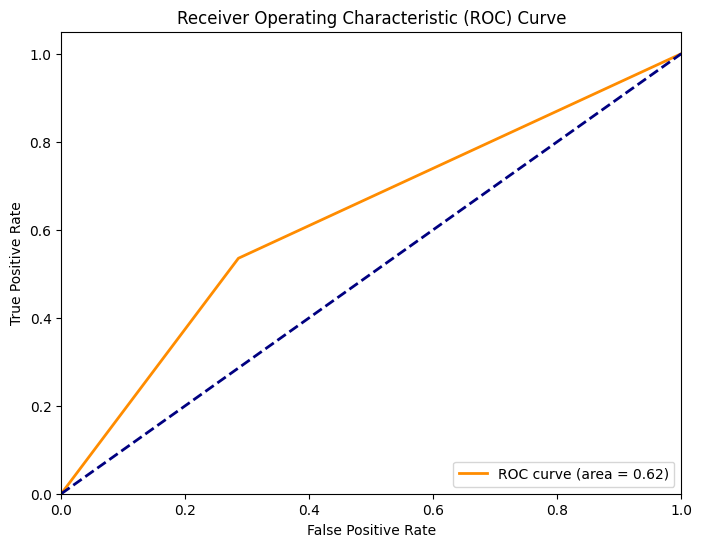

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC score
print("ROC AUC Score:", roc_auc)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print("######################### LOGISTIC REGRESSION: smote-tommelink ########################")

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.4, random_state=43, stratify=Y)



tomek = TomekLinks(sampling_strategy='auto')
smote_tomek = SMOTETomek(tomek=tomek, random_state=43)
X_bal, Y_bal = smote_tomek.fit_resample(X_train, Y_train)


lr_model = LogisticRegression(class_weight='balanced', random_state=43)
lr_model.fit(X_bal, Y_bal)

Y_pred = lr_model.predict(X_test)

print("Accuracy on test set (Logistic Regression):", accuracy_score(Y_test, Y_pred))
print("Classification Report:\n", classification_report(Y_test, Y_pred))

unique_labels = np.unique(np.concatenate((Y_test, Y_pred)))
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=unique_labels)

print("Confusion Matrix:")
print("  " + " ".join([f"Pred_{label}" for label in unique_labels]))
for i, label in enumerate(unique_labels):
    row = " ".join([str(count) for count in conf_matrix[i]])
    print(f"True_{label} {row}")

# Feature importance is not directly applicable to Logistic Regression like in Random Forest
# Coefficients of the model can be interpreted as feature importance

coefficients = lr_model.coef_[0]
for name, coef in zip(selected_features, coefficients):
    print(f"Feature: {name}, Coefficient: {coef}")

print()
print()



######################### LOGISTIC REGRESSION: smote-tommelink ########################
Accuracy on test set (Logistic Regression): 0.5069686411149826
Classification Report:
               precision    recall  f1-score   support

         0.0       0.20      0.80      0.32        82
         1.0       0.93      0.46      0.61       492

    accuracy                           0.51       574
   macro avg       0.57      0.63      0.47       574
weighted avg       0.83      0.51      0.57       574

Confusion Matrix:
  Pred_0.0 Pred_1.0
True_0.0 66 16
True_1.0 267 225
Feature: betweenness_BU, Coefficient: 0.3987196440078685
Feature: in_degree_BU, Coefficient: 0.6563345259009375
Feature: out_degree_BU, Coefficient: -0.3122559613384978
Feature: closeness_BU, Coefficient: 0.026544512315214448
Feature: CommunityBridgeIndex, Coefficient: 0.2793035227123104
Feature: influenceIndex, Coefficient: 0.1658529433174312
Feature: addettoVSmanager, Coefficient: -0.06191348122897907


